# Torch'ing things up!

Lets start using torch !

In [2]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# @title
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
    device = torch.device("cuda:0") # Use the first GPU
else:
    print("No GPU available. Training will run on CPU.")
    device = torch.device("cpu")

print(f"Using device: {device}")


GPU: NVIDIA A100-SXM4-40GB is available.
Using device: cuda:0


## Simple example of a toy neural net in torch!

This is just to warm up the brain for writing some code and also to have a reference for the basics of how torch should be used.

In [4]:
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

In [5]:

model = torch.nn.Sequential(
      torch.nn.Linear(1, 10),
      torch.nn.LeakyReLU(),
      torch.nn.Linear(10, 10),
      torch.nn.LeakyReLU(),
      torch.nn.Linear(10, 1)
)

In [6]:
x_train, x_test = x[:1600], x[1600:]
y_train, y_test = y[:1600], y[1600:]

x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

x_train = x_train.unsqueeze(-1)
x_test = x_test.unsqueeze(-1)


In [7]:
model.to(device)

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=10, out_features=1, bias=True)
)

In [8]:

loss_fn = torch.nn.L1Loss()
opt = torch.optim.Adagrad(params = model.parameters(),lr=0.01)

In [9]:
epochs = 100

In [10]:
for e in range(epochs):
  model.train(True)
  preds = model(x_train)
  loss = loss_fn(preds, y_train)
  opt.zero_grad()
  loss.backward()
  opt.step()
  print(f"Epoch: {e}, Loss: {loss.item()}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:132: UserWarning: Using a target size (torch.Size([1600])) that is different to the input size (torch.Size([1600, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 0, Loss: 0.7965441346168518
Epoch: 1, Loss: 0.7489492893218994
Epoch: 2, Loss: 0.7229583859443665
Epoch: 3, Loss: 0.7060922980308533
Epoch: 4, Loss: 0.6943273544311523
Epoch: 5, Loss: 0.6862462162971497
Epoch: 6, Loss: 0.6807591915130615
Epoch: 7, Loss: 0.6767178773880005
Epoch: 8, Loss: 0.6733000874519348
Epoch: 9, Loss: 0.6701703667640686
Epoch: 10, Loss: 0.6672030091285706
Epoch: 11, Loss: 0.6643455624580383
Epoch: 12, Loss: 0.6616623997688293
Epoch: 13, Loss: 0.6594176888465881
Epoch: 14, Loss: 0.6574410200119019
Epoch: 15, Loss: 0.6556175351142883
Epoch: 16, Loss: 0.6539175510406494
Epoch: 17, Loss: 0.6523216962814331
Epoch: 18, Loss: 0.6508179306983948
Epoch: 19, Loss: 0.6493966579437256
Epoch: 20, Loss: 0.6480509638786316
Epoch: 21, Loss: 0.6467753052711487
Epoch: 22, Loss: 0.6455650925636292
Epoch: 23, Loss: 0.6444168090820312
Epoch: 24, Loss: 0.643326461315155
Epoch: 25, Loss: 0.6422923803329468
Epoch: 26, Loss: 0.6413148045539856
Epoch: 27, Loss: 0.6403905153274536
Epo

In [11]:
# eval on test set
model.train(False)
preds = model(x_test)
loss = loss_fn(preds, y_test)
print(f"Test Loss: {loss.item()}")

Test Loss: 1.2500652074813843


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:132: UserWarning: Using a target size (torch.Size([400])) that is different to the input size (torch.Size([400, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [12]:
model(torch.tensor([0.5]).to(device))

tensor([-0.1791], device='cuda:0', grad_fn=<ViewBackward0>)

In [13]:
np.sin(0.5)

np.float64(0.479425538604203)

---
# Lets build a simple CNN and train it on MNIST using just torch autograd

Ref: http://yann.lecun.com/exdb/publis/pdf/lecun-iscas-10.pdf


First lets consider all the details , the CNN architecture mainly consists of 3 important pieces:
1. The filter bank of kernals
2. non-linearity
3. feature pooling

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ",device)

Using device:  cuda:0


## 1. Conv Step with filters

In [15]:
# First lets code up a convolution operation
def do_conv(
    x: torch.tensor,
    kernel: torch.tensor,
    bias: torch.tensor
):
  # Input will be a 3D Matrix
  c,w,h = x.shape
  print(f"X shape is {x.shape}")

  # kernal is a 2d tensor
  kc,kw,kh = kernel.shape
  print(f"kernel shape is {kernel.shape}")

  # Assumptions are best asserted in code.
  assert(kc == c)

  # output will be 3D matrix with results from the conv ops
  out = torch.zeros((c,w-kw+1,h-kh+1), device=x.device)
  print(f"Output shape is {out.shape}")

  for j in range(w - kw + 1):
    for k in range(h - kh + 1):
      patch = x[:,j:j+kw,k:k+kh]
      conv_result = torch.mul(patch,kernel)
      out[:,j,k] = torch.sum(conv_result,dim=(1,2)) + bias

  return out


In [16]:
import torch.nn.functional as F

In [17]:
C, H, W = 3, 7, 8
KH, KW = 3, 3
x = torch.randn(C, H, W, device=device)
w = torch.randn(C, KH, KW, device=device)
b = torch.tensor(0.1, device=device)

print(f"x device is {x.device}")
print(f"w device is {w.device}")
print(f"b device is {b.device}")

y_manual = do_conv(x, w, b)
y_torch = F.conv2d(x.unsqueeze(0), w.unsqueeze(0), bias=b.unsqueeze(0)).squeeze(0).squeeze(0)
print("Torch output shape: ",y_torch.shape)
print(torch.max(torch.abs(y_manual - y_torch)))


x device is cuda:0
w device is cuda:0
b device is cuda:0
X shape is torch.Size([3, 7, 8])
kernel shape is torch.Size([3, 3, 3])
Output shape is torch.Size([3, 5, 6])
Torch output shape:  torch.Size([5, 6])
tensor(11.7064, device='cuda:0')


we can see that torch conv2d does something different from what we have implemented! The shape of the torch output is only a 2D tensor but we are generating a 3D tensor! The difference you ask? Let's Analyze!

**Our implementation**
- input x: shape `(C=3, H, W)`
- kernel w: shape `(KH, KW)` - one 2D kernel and you loop over channels `i`
- For each channel we independently compute `y_i = conv2d(x_i, w) + b`
- This produces 3 separate output maps, i.e: one kernel is reused across all channels but the sum() op is done such that it only adds data from a single channel and never across channels.

> This is basically depthwise conv with a shared kernel (depthwise usually uses different kernels per channel, but the “no mixing” between the channels part is the key).


**What torch is doing**
- weight shape is `(C_out, C_in, KH, KW)`
- So when we say we want the output should be `C_out = 1, C_in = 3`, the channels are "mixed"(summed) over into one output map.

This is why you can see in the output of the previous cell:
```
Output shape is torch.Size([3, 5, 6])
Torch output shape:  torch.Size([5, 6])
```
Our implementation outputs an extra "channel" dimension while the torch output has already summed over that axis.


So lets make that small change and compare the values again!



In [18]:
def conv2d_like_torch(
    x: torch.Tensor,               # (C_in, H, W)
    w: torch.Tensor,               # (C_out, C_in, KH, KW)
    b: torch.Tensor | None = None  # (C_out,) or None
) -> torch.Tensor:
  # print(f"x shape is {x.shape} | {x.device}")
  # print(f"w shape is {w.shape} | {w.device}")
  C_in, H, W = x.shape
  C_out, C_in_w, KH, KW = w.shape
  assert C_in == C_in_w

  out_h = H - KH + 1
  out_w = W - KW + 1
  out = torch.zeros((C_out, out_h, out_w), dtype=x.dtype, device=x.device)

  for oc in range(C_out):
    for j in range(out_h):
      for k in range(out_w):
        patch = x[:, j:j+KH, k:k+KW]          # (C_in, KH, KW)
        out[oc, j, k] = (patch * w[oc]).sum() # sum over C_in,KH,KW
        if b is not None:
          out[oc, j, k] += b[oc]

  return out

In [19]:
C, H, W = 3, 12, 12
KH, KW = 3, 3

out_channels = 6
x = torch.randn(C, H, W, device=device)
w = torch.randn(out_channels,C,KH, KW,device=device) # Changed
b = torch.tensor(0.1,device=device).repeat((out_channels,)) # Changed

y_manual = conv2d_like_torch(x, w, b)
y_torch = F.conv2d(
    input = x.unsqueeze(0),
    weight = w, # Corrected weight shape
    bias = b, # Corrected bias shape
).squeeze(0) # Removed one squeeze operation
print("Manual output shape:",y_manual.shape)
print("Torch output shape: ",y_torch.shape)
print(torch.max(torch.abs(y_manual - y_torch)))

Manual output shape: torch.Size([6, 10, 10])
Torch output shape:  torch.Size([6, 10, 10])
tensor(2.8610e-06, device='cuda:0')


Awesome! we have a conv2d op that kinda works just like how torch does it, we still are missing some small pieces like stride and padding but the core is key!

Next lets build the non-linearity step!

## 2. Non-Linearity

Here we can write a simple ReLU or activation function, the idea is basically that this activation fn is applied per element over the output. We've implemented relu and leaky-relu in the previous notebook so I'll just goahead and use the torch version here.

In [20]:
out = conv2d_like_torch(x, w, b)
print(out.shape)
z = F.relu(out)
print(z.shape)

print(out[0])
print("""
Conv Outputs ^^

==========
Notice how the function is applied element-wise!
==========

After Activation
""")
print(z[0])

torch.Size([6, 10, 10])
torch.Size([6, 10, 10])
tensor([[ -4.2628,   4.0931,   2.7057,  -1.3682,   8.3933,   0.3624,   4.4993,
          -0.0514,  -2.0500,   3.8652],
        [ -8.7030,   8.9368,   5.4750,   0.8334,   2.5965,  10.3463, -16.3020,
          -2.0522,  17.8576,  -4.7644],
        [  0.0597, -11.6700,   4.4270,  -8.4285,   5.9975,   5.1286,  -1.6673,
           0.7746,   2.9898, -15.6718],
        [  5.8769,  14.0695,  -9.3457,  -3.6894,  -9.0683,  -5.7154,   1.4076,
          -3.7431,   0.1884,   3.5082],
        [  0.9250,  -7.1394,   1.2859,  -5.8900,  -2.5742,   6.0436,  -2.1926,
          -4.6113,  -4.9391,  -8.3861],
        [ -2.7889,  -2.9515,  -7.7820,  -5.0301,   1.5879,   8.1158,   6.8313,
           5.9296,  -0.9705,  -2.5105],
        [  2.5664,   9.4434,  -5.8846,  -0.3154,   4.5435,   1.8058,   4.9068,
          -6.2827,  -3.3517,  -0.1978],
        [  1.7198,  -2.2071,  -0.1362,   6.6191,   3.8913,  -8.2752,  -6.8544,
           4.2479,  -9.0866,  -4.8929],


## Pooling


In [21]:
def do_pooling(z,pool_size):
  feautre_count,h,w = z.shape

  pool_height,pool_width = pool_size
  # print(f"h={h} , pool_h = {pool_height}")
  # print(f"w={w} , pool_w = {pool_width}")
  assert(h % pool_height == 0)
  assert(w % pool_width == 0)

  out_h = h // pool_height
  out_w = w // pool_width

  out = torch.zeros((feautre_count,out_h,out_w),device=device)

  for  i in range(out_h):
    for j in range(out_w):
      patch_to_pool = z[:,i*pool_height,j*pool_width]
      pooled = torch.max(patch_to_pool)
      out[:,i,j] = pooled

  return out

In [22]:
# Lets test this

out = conv2d_like_torch(x, w, b)
print(out.shape)
z = F.relu(out)
print(z.shape)
# === POOLING ===
out_pool = do_pooling(z,pool_size=(2,2))
print(out_pool.shape)

torch.Size([6, 10, 10])
torch.Size([6, 10, 10])
torch.Size([6, 5, 5])


Awesome we can see that the output of the activation `z` of shape (6,10,10) was pooled down to (6,5,5) by a pooling filter of 2x2 :)


## Putting it all together!

Lets say we have inputs of size 28x28 which are images we need to classify into some target labels. How can we use a CNN to learn this? Lets design a network using our functions !

Defining Model Params

In [23]:
# Lets create a filter bank
conv_W1 = torch.randn((6,1,4,4) , requires_grad=True,device=device) # 6 filters , 1 channel each of 3x3 width_x_height
conv_b1 = torch.zeros(6, requires_grad=True,device=device)

# Weights for linear layer
W1 = torch.randn(10,6*1*5*5, requires_grad=True, device=device)
# Explaination for the shape , look at the last conv layer
# 6 filters
# 1 channel
# 25 steps for a width 4 filter to cover input width 28 @ stride 1
# 25 steps for a height 4 filter to cover input height 28 @ stride 1
# 6 * 1 * 25 * 25
# Then we do pooling with a 5x5 filter which converts it to :
# 6 * 1 * 5 * 5
# So will have a weight matrix of size (150,10) , 10 since we have to output classes in the prediction space.
b1 = torch.zeros(10, requires_grad=True, device=device)

print(f"conv_W1 shape is {conv_W1.shape}")
print(f"conv_b1 shape is {conv_b1.shape}")
print(f"W1 shape is {W1.shape}")
print(f"b1 shape is {b1.shape}")

conv_W1 shape is torch.Size([6, 1, 4, 4])
conv_b1 shape is torch.Size([6])
W1 shape is torch.Size([10, 150])
b1 shape is torch.Size([10])


**Define Loss Function and Optimizer**

In [24]:
# Defining Loss Fn and Optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optm = torch.optim.Adam(params=[conv_W1,conv_b1,W1,b1],lr=0.01)

**Define a forward pass**


Think of the conv step as "feature" extractors and the linear layer like the predictors which learn from the extacted features.

In [25]:
def forward_pass(x):
  # print(x.device)
  o = conv2d_like_torch(x,conv_W1,conv_b1)
  # print(f"training: input {x.shape} -- conv2d --> {o.shape} | {o.device}")
  z = F.relu(o)
  p = do_pooling(z,(5,5))
  # print(f"training: pooling {z.shape} -- pool --> {p.shape} | {p.device}")
  # This is the conv part , we still need a linear part to make predictions
  flat = p.flatten().to(device)
  # print(f"training: {p.shape} -- flattened to --> {flat.shape}")
  logits = F.linear(flat,W1,b1)
  # print(f"training: logits shape is {logits.shape}")
  # Finally we will use a softmax on the logits to create a probability distribusion of the prediction across all possible classes( 1 to 10)
  preds = F.softmax(logits,dim=0)
  # print(f"training: preds shape is {preds.shape}")
  return preds


In [26]:
# @title
random_data = torch.randn((1,28,28),device=device)
# Ensure forward_pass_2 returns logits, which is what it does now.
# For a sanity check, we might want to see the logits or apply softmax for interpretation.
logits_output = forward_pass(random_data)
print(f"Logits output shape: {logits_output.shape}")
# If you want to see probabilities, apply softmax here (but not in the forward_pass_2 itself for training with CrossEntropyLoss)
preds_output = F.softmax(logits_output, dim=0)
print(f"Probabilities output (after softmax): {preds_output}")

Logits output shape: torch.Size([10])
Probabilities output (after softmax): tensor([0.0856, 0.0856, 0.0856, 0.0856, 0.0856, 0.2283, 0.0856, 0.0856, 0.0856,
        0.0872], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Forward pass work ✅

Lets write a training loop

In [27]:
from tqdm import tqdm

In [28]:
def train(x_train: torch.tensor, y_train):
  loss_history = []
  for e in range(epochs):
    count = x_train.shape[0]
    tqdm_iter = tqdm(range(count))
    for i in tqdm_iter:
      inp = x_train[i]
      preds = forward_pass(inp if inp.shape == (1,28,28) else inp.reshape(1,28,28))
      loss = loss_fn(preds,y_train[i])
      optm.zero_grad()
      loss.backward()
      optm.step()
      tqdm_iter.set_description(f"Epoch: {e}, Loss: {loss.item()}")
    print(f"Epoch: {e}, Loss: {loss.item()}")
    loss_history.append(loss.item())
  return loss_history

### Setup a dataset: MNIST

Using https://docs.pytorch.org/tutorials/beginner/nn_tutorial.html#mnist-data-setup

(50000, 784)


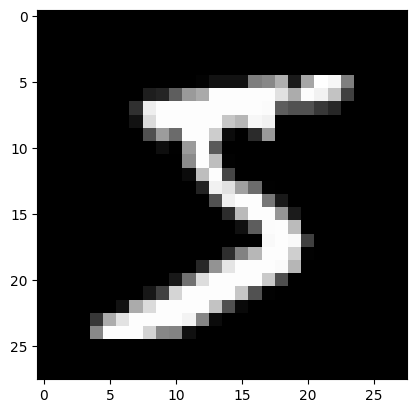

In [29]:
# @title
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
# ``pyplot.show()`` only if not on Colab
try:
    import google.colab
except ImportError:
    pyplot.show()
print(x_train.shape)


In [30]:
x_train.shape

(50000, 784)

In [31]:
y_train.shape

(50000,)

### Training Time!


In [32]:
x_train_tensor = torch.from_numpy(x_train).float().reshape(-1, 1, 28, 28).to(device)
# y_train needs to be integer labels for CrossEntropyLoss
y_train_tensor = torch.from_numpy(y_train).long().to(device)

print(x_train_tensor.shape , x_train_tensor.device)
print(y_train_tensor.shape, y_train_tensor.device)

torch.Size([50000, 1, 28, 28]) cuda:0
torch.Size([50000]) cuda:0


In [33]:
 # loss_hist = train(x_train_tensor[:10], y_train_one_hot[:10])

Well while this works, its ridiculously slow! its as if using a GPU here is almost making no difference, why is that? thats cause we are using a triple loop in out conv2d operation, and GPUs hate loops!

### Vectorizing Ops
Lets explore the "unfold" op on torch which will help us speed things up

In [34]:
x = x_train_tensor[:10]
x.shape

torch.Size([10, 1, 28, 28])

In [35]:
r = F.unfold(x,kernel_size=(4,4),stride=1)
print(r.shape)
# torch.Size([10, 16, 625])
# 10 = no of samples
# 16 is the flattened size of the patch we wish to create
# 625 is the flattened size of the conv operation on a single sample

"""
What unfold really does is flattens the spatial dims while leaving the batch and channel dims unchanged.
"""

torch.Size([10, 16, 625])


'\nWhat unfold really does is flattens the spatial dims while leaving the batch and channel dims unchanged.\n'

In [36]:
def conv2d_unfold_batch(x, w, b=None):
    # x: (batch,C_in, H, W)  !!! CHANGE !!!
    # w: (C_out, C_in, KH, KW)
    batch,C_in, H, W_ = x.shape
    C_out, C_in_w, KH, KW = w.shape
    assert C_in == C_in_w

    # (C_in*KH*KW, out_h*out_w)
    cols = torch.nn.functional.unfold(x, kernel_size=(KH, KW))  # (C_in*KH*KW, L)

    w_flat = w.view(C_out, -1)                                               # (C_out, Ck)

    # Note that conv originally implemeted a element-wise multiply and sum()
    # the same is done when we do the below dot product with @ since cols and
    # w_flat are setup as above.
    out = (w_flat @ cols)                                                    # (C_out, L)

    out_h = H - KH + 1
    out_w = W_ - KW + 1
    out = out.view(batch,C_out, out_h, out_w)

    if b is not None:
        out = out + b.view(-1, 1, 1)

    return out

In [37]:
# @title
N, C_in, H, W = 32, 3, 12, 12
C_out, KH, KW = 5, 3, 3

X = torch.randn(N, C_in, H, W, device="cuda")
W = torch.randn(C_out, C_in, KH, KW, device="cuda")
b = torch.randn(C_out, device="cuda")

y1 = conv2d_unfold_batch(X, W, b)
y2 = F.conv2d(X, W, b)

# low diff indicates our implementation is close to how torch does it internally!
print((y1 - y2).abs().max())
print(y1.shape)

tensor(4.7684e-06, device='cuda:0')
torch.Size([32, 5, 10, 10])


In [38]:
def batch_pooling(x,pool_size):
  # print(x.shape)
  batch,feautre_count,h,w = x.shape
  # print(f"x shape = {x.shape}")
  pool_height,pool_width = pool_size

  # since we are not padding and have fixed striding of pool_size
  assert(h % pool_height == 0)
  assert(w % pool_width == 0)

  out_h = h // pool_height
  out_w = w // pool_width

  # This should create a tensor of shape (batch, ft_count * h * w)
  cols = F.unfold(x,kernel_size=pool_size,stride=pool_size)
  # print(f"Shape after unfolding for pool is {cols.shape}")
  cols = cols.view(batch,feautre_count, (pool_height * pool_width), -1)
  # print(f"Shape after unfolding-RESHAPE for pool is {cols.shape}")

  max_pooled = cols.max(dim=2).values
  res = max_pooled.view(batch,feautre_count,out_h,out_w)
  # print(f"Shape after pooling is {res.shape}")
  return res

In [39]:
# @title
my_p = batch_pooling(y1,(2,2))
torch_p = F.max_pool2d(y1,(2,2))
print(my_p.shape)
print(torch_p.shape)
# compare values
print(torch.max(torch.abs(my_p - torch_p)))

torch.Size([32, 5, 5, 5])
torch.Size([32, 5, 5, 5])
tensor(0., device='cuda:0')


In [40]:
def forward_pass_2(x_batch):
  # print(x.device)
  o = conv2d_unfold_batch(x_batch,conv_W1,conv_b1)
  # print(f"training: input {x.shape} -- conv2d --> {o.shape} | {o.device}")
  z = F.relu(o)
  p = batch_pooling(z,torch.tensor((5,5))) # !!! CHANGED !!!
  # print(f"training: pooling {z.shape} -- pool --> {p.shape} | {p.device}")
  # This is the conv part , we still need a linear part to make predictions
  flat = p.flatten(start_dim=1).to(device) # avoid falttening the batch dim
  # print(f"training: {p.shape} -- flattened to --> {flat.shape}")
  logits = F.linear(flat,W1,b1)
  # print(f"training: logits shape is {logits.shape}")
  # For CrossEntropyLoss, we return raw logits. Softmax is applied externally for prediction.
  # preds = F.softmax(logits,dim=1)
  # print(f"training: preds shape is {preds.shape}")
  return logits

In [41]:
def train_2(x_train: torch.tensor, y_train,batch_size = 128):
  loss_history = []
  for e in range(epochs):
    count = x_train.shape[0]
    tqdm_iter = tqdm(range(0,count,batch_size))
    for i in tqdm_iter:
      inp = x_train[i:i+batch_size]
      preds = forward_pass_2(inp) # preds are now logits
      target = y_train[i: i+batch_size] # target are integer labels
      # print(f"preds {preds.shape}\n targets: {target.shape}")
      loss = loss_fn(preds,target)
      optm.zero_grad()
      loss.backward()
      optm.step()
      tqdm_iter.set_description(f"Epoch: {e}, Loss: {loss.item()}")
    # print(f"Epoch: {e}, Loss: {loss.item()}")
    loss_history.append(loss.item())
  return loss_history

In [42]:
loss_hist = train_2(x_train_tensor[:10], y_train_tensor[:10])

Epoch: 99, Loss: 0.007834041491150856: 100%|██████████| 1/1 [00:00<00:00, 336.78it/s]


FASTTT! Now lets train the network with the full training dataset!

In [43]:
loss_hist = train_2(x_train_tensor, y_train_tensor)

Epoch: 99, Loss: 0.04816671460866928: 100%|██████████| 391/391 [00:01<00:00, 276.02it/s]


In [44]:
def predict(x):
  with torch.no_grad():
    logits = forward_pass_2(x)
    preds = F.softmax(logits, dim=1)
  return preds

In [45]:
x_test_tensor = torch.from_numpy(x_valid).float().reshape(-1, 1, 28, 28).to(device)
y_test_tensor = torch.from_numpy(y_valid).long().to(device)

correct_predictions = 0
total_predictions = 0
batch_size = 128 # Use the same batch size as in training

for i in range(0, x_test_tensor.shape[0], batch_size):
    inp_batch = x_test_tensor[i:i+batch_size]
    target_batch = y_test_tensor[i:i+batch_size]

    preds = predict(inp_batch)
    predicted_labels = torch.argmax(preds, dim=1)

    correct_predictions += (predicted_labels == target_batch).sum().item()
    total_predictions += target_batch.size(0)

accuracy = correct_predictions / total_predictions
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.9771


🎉 Wohoo! IT worked!

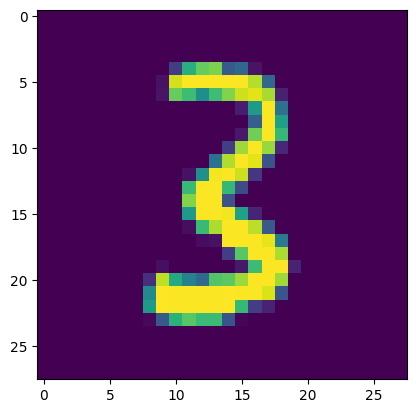

In [56]:
t_img = x_test_tensor[0].squeeze().cpu()
plt.imshow(t_img)

In [58]:
t_preds = predict(x_test_tensor[0].unsqueeze(0))
print(t_preds)
t_preds.argmax()

tensor([[4.3910e-16, 4.3141e-14, 1.6882e-06, 9.9999e-01, 3.1150e-16, 7.2040e-06,
         2.0771e-10, 4.4437e-13, 4.4248e-07, 2.0838e-11]], device='cuda:0')


tensor(3, device='cuda:0')